In [1]:
import pandas as pd # Librería para análisis de datos
import numpy as np # Librería para análisis numérico
from scipy import stats # Librería para estadísticas
from statsmodels.stats.proportion import proportions_ztest # Librería para prueba de hipótesis
import matplotlib.pyplot as plt # Librería para graficos
import seaborn as sns # Librería para graficos

In [2]:
df_final_demo = pd.read_csv( "data/raw/df_final_demo.txt",sep= ',')
df_final_experiment_clients = pd.read_csv( "data/raw/df_final_experiment_clients.txt",sep= ',')

#Carga de las dos partes 
df_webdata1 = pd.read_csv('data/raw/df_final_web_data_pt_1.txt', sep=',')
df_webdata2 = pd.read_csv('data/raw/df_final_web_data_pt_2.txt', sep=',')

#### 1.Exploracion de los datos.

In [3]:
df_final_demo.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 70609 entries, 0 to 70608
Data columns (total 9 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   client_id         70609 non-null  int64  
 1   clnt_tenure_yr    70595 non-null  float64
 2   clnt_tenure_mnth  70595 non-null  float64
 3   clnt_age          70594 non-null  float64
 4   gendr             70595 non-null  object 
 5   num_accts         70595 non-null  float64
 6   bal               70595 non-null  float64
 7   calls_6_mnth      70595 non-null  float64
 8   logons_6_mnth     70595 non-null  float64
dtypes: float64(7), int64(1), object(1)
memory usage: 4.8+ MB


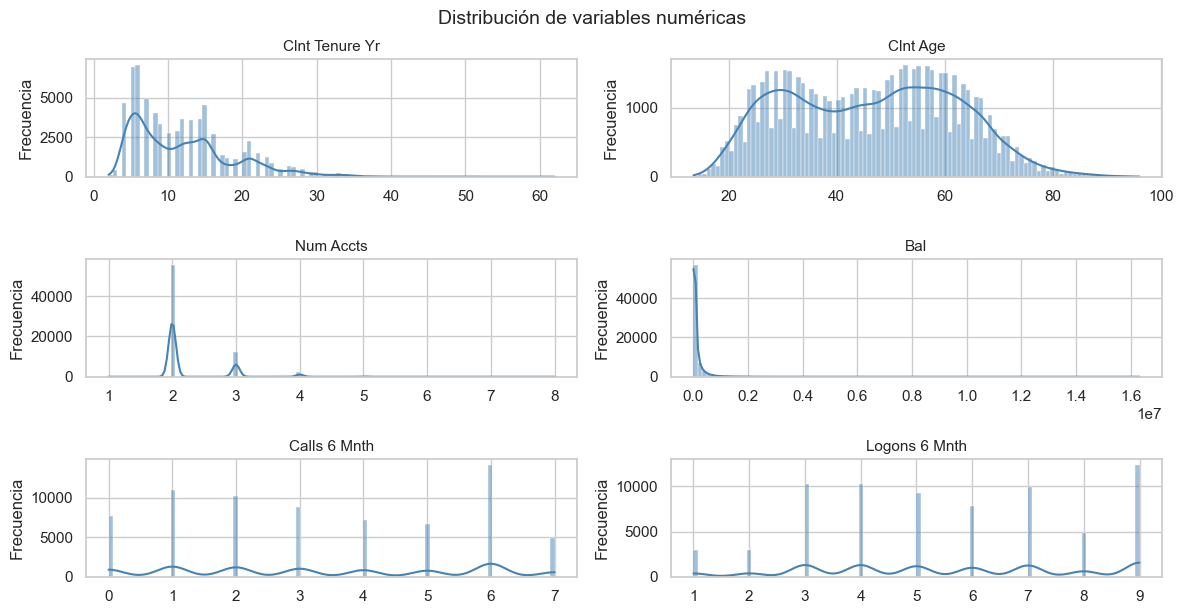

In [4]:
def plot_variables_numericas(df, cols):
    """
    Grafica la distribución de variables numéricas usando histogramas con KDE.

    Parameters:
        df (DataFrame): DataFrame de entrada.
        cols (list): Lista de nombres de columnas numéricas a graficar.
    """
    sns.set(style="whitegrid")
    plt.figure(figsize=(12, 6))
    for idx, col in enumerate(cols, 1):
        plt.subplot(3, 2, idx)
        sns.histplot(df[col], bins=100, kde=True, color='steelblue')
        plt.title(col.replace('_', ' ').title(), fontsize=11)
        plt.xlabel('')
        plt.ylabel('Frecuencia')
    plt.tight_layout()
    plt.suptitle('Distribución de variables numéricas', fontsize=14, y=1.02)
    plt.show()

# Uso de la función
cols_to_plot = ['clnt_tenure_yr', 'clnt_age', 'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth']
cols_to_plot = [col for col in cols_to_plot if col in df_final_demo.columns]
plot_variables_numericas(df_final_demo, cols_to_plot)

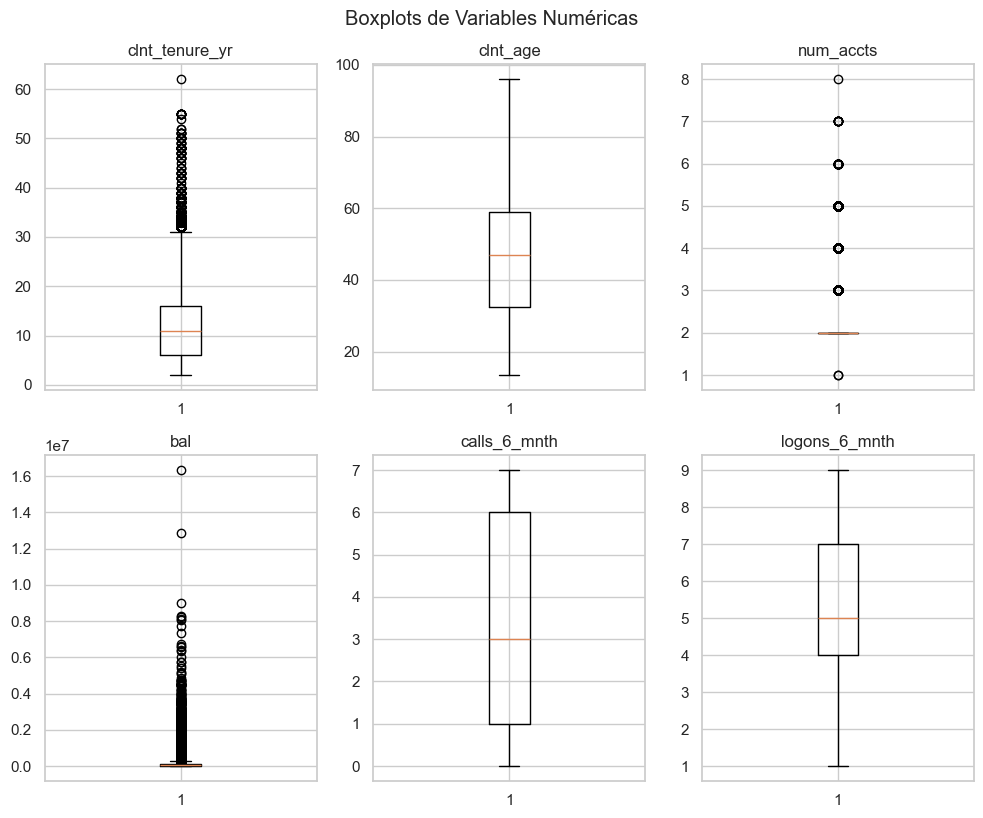

In [5]:
# comrpobamos outliers de las diferentes variables
def outliers_boxplots(df):
    """
    Genera caja de bigotes para cada columna numérica en el DataFrame proporcionado.
    
    Parameters:
        df (DataFrame): DataFrame que contiene las columnas numéricas.
    """

    # Configurar el tamaño de la figura
    num_columns = df.shape[1]
    num_rows = (num_columns // 3) + (num_columns % 3 > 0)  # Calcular número de filas necesarias
    plt.figure(figsize=(10, num_rows * 4))  # Ajustar el tamaño en función del número de filas

    # Iterar sobre cada columna y generar un boxplot
    for i, column in enumerate(df.columns):
        plt.subplot(num_rows, 3, i + 1)  # Cambia el tamaño de la cuadrícula según el número de columnas
        plt.boxplot(df[column].dropna())  # Elimina valores NaN antes de graficar
        plt.title(column)
        plt.grid(True)

    plt.tight_layout()  # Ajustar el espaciado entre los gráficos
    plt.suptitle('Boxplots de Variables Numéricas', y=1.02)  # Ajustar el título para que no se superponga
    plt.show()
    
outliers_boxplots(df_final_demo[cols_to_plot])

#### **2.Limpieza y union de los datasets**

#### **2.1 Limpieza**

In [6]:
def limpieza_demograficos(df):
    """
    Limpia y transforma el dataset demográfico aplicando varias reglas:

    Descripción de pasos:
    ---------------------
    1. Elimina registros duplicados y filas con valores faltantes.
    2. Convierte ciertas columnas a tipo entero ('clnt_tenure_yr', 'clnt_age', 'num_accts', 'logons_6_mnth', 'calls_6_mnth') y reemplaza 'X' por 'U' en la columna 'gendr'.
    3. Filtra los datos para conservar solo clientes mayores de 18 años y con menos de 40 años de permanencia.
    4. Clasifica la columna 'bal' en categorías: 'bajo', 'medio' y 'alto'.
    5. Elimina registros donde la permanencia es mayor que la edad del cliente.
    6. Segmenta los clientes en 'new' o 'long_tenure' según los años de permanencia.
    7. Agrupa a los clientes por edad en segmentos usando el rango intercuartílico (IQR).
    8. Selecciona únicamente las columnas necesarias para el análisis final.

    Parámetros:
    -----------
    df : DataFrame
        Datos demográficos originales.

    Retorna:
    --------
    DataFrame limpio y transformado, listo para análisis.
    """
    # 1
    df = df.drop_duplicates()
    df = df.dropna()

    # 2
    df[["clnt_tenure_yr","clnt_age","num_accts","logons_6_mnth","calls_6_mnth"]] = df[["clnt_tenure_yr","clnt_age","num_accts","logons_6_mnth","calls_6_mnth"]].astype(int)
    df["gendr"] = df["gendr"].replace({"X": "U"})

    # 3
    df = df[(df["clnt_age"] >= 18) & (df["clnt_tenure_yr"] < 40)]

    # 4
    # Clasificación de balances en categorías usando cuantiles
    df['bal_category'] = pd.qcut(df['bal'], q=[0, 0.25, 0.75, 1], labels=['bajo', 'medio', 'alto'])

    # 5
    indices_a_eliminar = df[df["clnt_tenure_yr"] > df["clnt_age"]].index
    df = df.drop(indices_a_eliminar)

    # 6
    df['tenure_segment'] = np.where(df['clnt_tenure_yr'] < 10, 'new', 'long_tenure')

    # 7 - Segmentación por edad usando IQR
    Q1 = df['clnt_age'].quantile(0.25)
    Q3 = df['clnt_age'].quantile(0.75)
    IQR = Q3 - Q1

    def age_iqr_segment(age):
        if age < Q1:
            return 'young'
        elif age > Q3:
            return 'old'
        else:
            return 'middle'

    df['age_segment'] = df['clnt_age'].apply(age_iqr_segment)

    # 8
    df = df[["client_id", "clnt_tenure_yr", "clnt_age", "gendr", "num_accts", "bal", "calls_6_mnth", "logons_6_mnth", "tenure_segment", "age_segment",'bal_category']]

    return df

In [7]:
df_final_demo_cleaned = limpieza_demograficos(df_final_demo)
df_final_demo_cleaned.to_csv("data/cleaned/df_final_demo_clean.csv", index=False)

In [8]:
df_final_demo_cleaned.head(10)

,client_id,clnt_tenure_yr,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,tenure_segment,age_segment,bal_category
0,836976,6,60,U,2,45105.30,6,9,new,old,medio
1,2304905,7,58,U,2,110860.30,6,9,new,middle,medio
2,1439522,5,32,U,2,52467.79,6,9,new,young,medio
3,1562045,16,49,M,2,67454.65,3,6,long_tenure,middle,medio
4,5126305,12,33,F,2,103671.75,0,3,long_tenure,middle,medio
5,3727881,5,30,U,2,23915.60,0,3,new,young,bajo
6,272934,5,58,U,2,27021.42,2,5,new,middle,bajo
7,388801,30,57,M,5,522498.72,1,4,long_tenure,middle,alto
8,285619,30,67,M,2,299388.72,3,6,long_tenure,old,alto
9,8198645,15,54,F,2,382303.83,6,9,long_tenure,middle,alto


In [9]:
# Hacemos el merge de los datos de webdata y los limpiamos. 

def limpieza_webdata(df1, df2):
    """
    hace un merge de los dos DataFrames de datos web y aplica transformaciones para su limpieza y análisis.

    Descripción:
    -------------------------------
    1. Combina ambos DataFrames en uno solo.
    2. Convierte la columna 'date_time' al tipo datetime.
    3. Ordena los datos por 'client_id', 'visit_id' y 'date_time'.
    4. Genera la columna 'is_complete' para marcar procesos finalizados.
    5. Calcula el tiempo transcurrido entre cada paso ('time_diff_step').
    6. Establece el orden lógico de los pasos del proceso.
    7. Identifica el paso anterior y detecta posibles errores en la secuencia.

    Parámetros:
    -----------
    df1, df2 : pd.DataFrame
        DataFrames con los datos web a combinar.

    Retorna:
    --------
    pd.DataFrame
        DataFrame combinado y transformado listo para análisis.
    """
    # 1
    merged_df = pd.concat([df1, df2], ignore_index=True)

    # 2
    merged_df["date_time"] = pd.to_datetime(merged_df["date_time"])

    # 3
    merged_df = merged_df.sort_values(by=['client_id', 'visit_id', 'date_time'])

    # 4
    final_steps = ['confirm']
    merged_df['is_complete'] = merged_df.groupby('client_id')['process_step'].transform(lambda x: 'Complete' if final_steps[0] in x.values else 'Incomplete')
    merged_df['is_complete'] = merged_df['is_complete'].replace({'Complete': 1, 'Incomplete': 0})

    # 5
    merged_df['time_before_step'] = merged_df.groupby(['client_id', 'visitor_id', 'visit_id'])['date_time'].shift(1)
    merged_df['time_diff_step'] = (merged_df['date_time'] - merged_df['time_before_step']).dt.total_seconds()

    # 6
    step_order = ['start', 'step_1', 'step_2', 'step_3', 'confirm']
    merged_df['process_step'] = pd.Categorical(merged_df['process_step'], categories=step_order, ordered=True)
    merged_df['prev_process_step'] = merged_df.groupby(['client_id', 'visit_id'])['process_step'].shift(1)

    # 7
    merged_df['is_error'] = merged_df['process_step'] < merged_df['prev_process_step']
    merged_df['is_error'] = merged_df['is_error'].fillna(False)


    return merged_df

# Llamamos a la funcion para hacer el merge de los datos 
df_final_webdata = limpieza_webdata(df_webdata1, df_webdata2)

# se guarda en la carpeta files para usarlo en el futuro 
df_final_webdata.to_csv('data/cleaned/df_final_web_data.csv', index=False)

#Cargamos el dataframe final para comprobar que se ha guardado correctamente. 
df_final_webdata = pd.read_csv('data/cleaned/df_final_web_data.csv',sep=',')
df_final_webdata.head(10)

C:\Users\franc\AppData\Local\Temp\ipykernel_5140\2784657616.py:39: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  merged_df['is_complete'] = merged_df['is_complete'].replace({'Complete': 1, 'Incomplete': 0})


,client_id,visitor_id,visit_id,process_step,date_time,is_complete,time_before_step,time_diff_step,prev_process_step,is_error
0,169,201385055_71273495308,749567106_99161211863_557568,start,2017-04-12 20:19:36,1,NaN,NaN,NaN,False
1,169,201385055_71273495308,749567106_99161211863_557568,step_1,2017-04-12 20:19:45,1,2017-04-12 20:19:36,9.0,start,False
2,169,201385055_71273495308,749567106_99161211863_557568,step_2,2017-04-12 20:20:31,1,2017-04-12 20:19:45,46.0,step_1,False
3,169,201385055_71273495308,749567106_99161211863_557568,step_3,2017-04-12 20:22:05,1,2017-04-12 20:20:31,94.0,step_2,False
4,169,201385055_71273495308,749567106_99161211863_557568,confirm,2017-04-12 20:23:09,1,2017-04-12 20:22:05,64.0,step_3,False
5,336,64757908_3400128256,649044751_80905125055_554468,start,2017-06-01 07:26:55,0,NaN,NaN,NaN,False
6,336,64757908_3400128256,649044751_80905125055_554468,start,2017-06-01 07:42:43,0,2017-06-01 07:26:55,948.0,start,False
7,546,475037402_89828530214,731811517_9330176838_94847,start,2017-06-17 10:03:29,1,NaN,NaN,NaN,False
8,546,475037402_89828530214,731811517_9330176838_94847,step_1,2017-06-17 10:03:39,1,2017-06-17 10:03:29,10.0,start,False
9,546,475037402_89828530214,731811517_9330176838_94847,step_2,2017-06-17 10:03:52,1,2017-06-17 10:03:39,13.0,step_1,False


In [10]:
def limpieza_experiment(df):
    """
    Limpia los datos del proceso experimental de clientes.

    Operaciones realizadas:
    -----------------------
    1. Eliminar valores nulos:
       - Se eliminan las filas que contienen valores nulos en cualquier columna del DataFrame.
       - La accion corresponde a trabajar solo con clientes que pertenecieron a un grupo control o test.

    Parameters:
    -----------
    df : pd.DataFrame
        DataFrame con los datos de clientes experimentales.

    Returns:
    --------
    pd.DataFrame
        DataFrame limpio sin valores nulos.
    """
    # 1
    df = df.dropna()

    return df

In [11]:
limpieza_experiment(df_final_experiment_clients).to_csv('data/cleaned/df_final_experiment_clients_clean.csv', index=False)

In [12]:
df_final_experiment_clients.head()

,client_id,Variation
0,9988021,Test
1,8320017,Test
2,4033851,Control
3,1982004,Test
4,9294070,Control


In [13]:
def merge_datasets(web_data, experiment_data, demo_data):
    """
    Une los datasets de datos web, experimentales y demográficos usando 'client_id',
    incluyendo solo aquellos clientes presentes en los tres conjuntos y que tengan grupo asignado.

    Retorna:
    --------
    pd.DataFrame
        DataFrame final con solo los 'client_id' comunes y sin valores nulos en 'Variation'.
    """
    # Intersección de client_id en los tres datasets
    common_clients = set(web_data['client_id']) & set(experiment_data['client_id']) & set(demo_data['client_id'])

    # Filtrar por client_id comunes
    web_data_filtered = web_data[web_data['client_id'].isin(common_clients)]
    experiment_data_filtered = experiment_data[experiment_data['client_id'].isin(common_clients)]
    demo_data_filtered = demo_data[demo_data['client_id'].isin(common_clients)]

    # Merges
    df_merged = pd.merge(web_data_filtered, experiment_data_filtered, on="client_id", how="inner")
    df_final = pd.merge(df_merged, demo_data_filtered, on="client_id", how="inner")

    # Eliminar filas sin grupo asignado (Variation nulo)
    df_final = df_final[df_final['Variation'].notna()]

    return df_final



In [14]:
df_final = merge_datasets(df_final_webdata, df_final_experiment_clients, df_final_demo_cleaned)

df_final.to_csv('data/cleaned/df_final.csv', index=False)

In [15]:
# comprobar los nulos de df_final
df_final.isnull().sum()


client_id                0
visitor_id               0
visit_id                 0
process_step             0
date_time                0
is_complete              0
time_before_step     68863
time_diff_step       68863
prev_process_step    68863
is_error                 0
Variation                0
clnt_tenure_yr           0
clnt_age                 0
gendr                    0
num_accts                0
bal                      0
calls_6_mnth             0
logons_6_mnth            0
tenure_segment           0
age_segment              0
bal_category             0
dtype: int64

In [16]:
df_final.head(10)

,client_id,visitor_id,visit_id,process_step,date_time,is_complete,time_before_step,time_diff_step,prev_process_step,is_error,...,clnt_tenure_yr,clnt_age,gendr,num_accts,bal,calls_6_mnth,logons_6_mnth,tenure_segment,age_segment,bal_category
5,555,402506806_56087378777,637149525_38041617439_716659,start,2017-04-15 12:57:56,1,NaN,NaN,NaN,False,...,3,29,U,2,25454.66,2,6,new,young,bajo
6,555,402506806_56087378777,637149525_38041617439_716659,step_1,2017-04-15 12:58:03,1,2017-04-15 12:57:56,7.0,start,False,...,3,29,U,2,25454.66,2,6,new,young,bajo
7,555,402506806_56087378777,637149525_38041617439_716659,step_2,2017-04-15 12:58:35,1,2017-04-15 12:58:03,32.0,step_1,False,...,3,29,U,2,25454.66,2,6,new,young,bajo
8,555,402506806_56087378777,637149525_38041617439_716659,step_3,2017-04-15 13:00:14,1,2017-04-15 12:58:35,99.0,step_2,False,...,3,29,U,2,25454.66,2,6,new,young,bajo
9,555,402506806_56087378777,637149525_38041617439_716659,confirm,2017-04-15 13:00:34,1,2017-04-15 13:00:14,20.0,step_3,False,...,3,29,U,2,25454.66,2,6,new,young,bajo
10,647,66758770_53988066587,40369564_40101682850_311847,start,2017-04-12 15:41:28,1,NaN,NaN,NaN,False,...,12,57,M,2,30525.80,0,4,long_tenure,middle,bajo
11,647,66758770_53988066587,40369564_40101682850_311847,step_1,2017-04-12 15:41:35,1,2017-04-12 15:41:28,7.0,start,False,...,12,57,M,2,30525.80,0,4,long_tenure,middle,bajo
12,647,66758770_53988066587,40369564_40101682850_311847,step_2,2017-04-12 15:41:53,1,2017-04-12 15:41:35,18.0,step_1,False,...,12,57,M,2,30525.80,0,4,long_tenure,middle,bajo
13,647,66758770_53988066587,40369564_40101682850_311847,step_3,2017-04-12 15:45:02,1,2017-04-12 15:41:53,189.0,step_2,False,...,12,57,M,2,30525.80,0,4,long_tenure,middle,bajo
14,647,66758770_53988066587,40369564_40101682850_311847,confirm,2017-04-12 15:47:45,1,2017-04-12 15:45:02,163.0,step_3,False,...,12,57,M,2,30525.80,0,4,long_tenure,middle,bajo


##### Resumen de Principales Actos de Limpieza de Datos en el EDA

1. **Limpieza de Inconsistencias**:
   - **Usuarios menores de 18 años**: Se eliminan aquellos registros de clientes que tenían menos de 18 años, ya que no son usuarios validos para el estudio. 
   - **Clientes con permanencia mayor que su edad**: se eliminan aquellos que su permanencia es superior a su edad y se asume que no son datos logicos ni reales. 

2. **Limpieza de Outliers**:
   - **Variable `bal` (Balance)**: Se observó una alta variabilidad en los balances con valores extremos significativos. Para reducir el impacto de los outliers, los datos fueron recategorizados en tres grupos: **bajo**, **medio** y **alto**, permitiendo un análisis más manejable y centrado en en datos relevantes para el negocio.

3. **Eliminación de Variables Redundantes**:
   - **Tiempo de permanencia en meses**: Se eliminó la variable `clnt_tenure_mnth` (tiempo de permanencia en meses) debido a que nos da la misma informacion que `clnt_tenure_yr` (tiempo de permanencia en años), no aporta valor al estudio.  

#### **2.2 Exploración de los datos.**

C:\Users\franc\AppData\Local\Temp\ipykernel_5140\2109366852.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


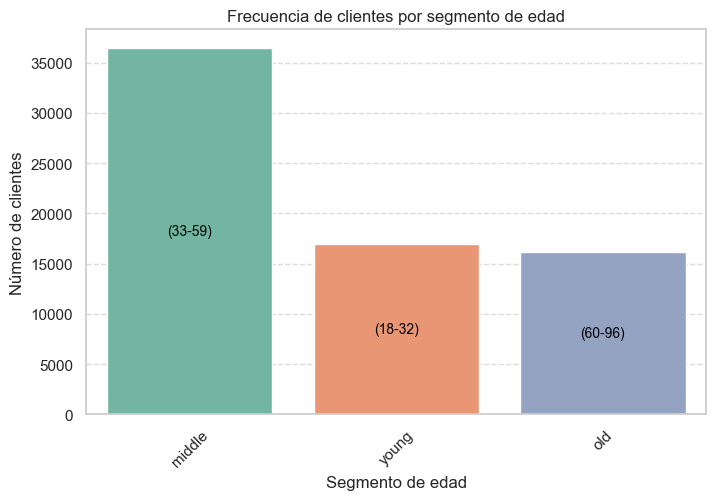

In [17]:
def plot_age_segment_distribution(df):
    """
    Grafica la frecuencia de clientes por segmento de edad y muestra los rangos de edad en cada barra.

    Parámetros:
    -----------
    df : DataFrame
        DataFrame limpio con las columnas 'age_segment' y 'clnt_age'.
    """
    age_frequency_table = df['age_segment'].value_counts()
    # Definir los rangos de edad para cada segmento
    age_ranges = {
        segment: f"{df[df['age_segment'] == segment]['clnt_age'].min()}-{df[df['age_segment'] == segment]['clnt_age'].max()}"
        for segment in age_frequency_table.index
    }

    plt.figure(figsize=(8, 5))
    sns.barplot(
        x=age_frequency_table.index,
        y=age_frequency_table.values,
        palette="Set2"
    )
    # Añadir etiquetas del rango de edad
    for i, segment in enumerate(age_frequency_table.index):
        plt.text(
            i,
            age_frequency_table.values[i] / 2,
            f"({age_ranges[segment]})",
            ha='center', va='center', fontsize=10, color='black'
        )

    plt.xticks(rotation=45)
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.title('Frecuencia de clientes por segmento de edad')
    plt.xlabel('Segmento de edad')
    plt.ylabel('Número de clientes')
    plt.show()

# Uso de la función
plot_age_segment_distribution(df_final_demo_cleaned)

In [18]:
def plot_age_distribution_by_segment(df, age_col='clnt_age', segment_col='age_segment'):
    """
    Grafica la distribución de edad por segmento usando un histograma apilado.

    Parámetros:
        df (DataFrame): DataFrame de entrada.
        age_col (str): Nombre de la columna de edad.
        segment_col (str): Nombre de la columna de segmento de edad.
    """
    plt.figure(figsize=(10, 6))
    sns.histplot(
        data=df,
        x=age_col,
        bins=100,
        kde=False,
        color="steelblue",
        hue=segment_col,
        multiple="stack",
        palette="Set2"
    )
    plt.title('Distribución de edad por segmento')
    plt.xlabel('Edad')
    plt.ylabel('Frecuencia')
    plt.show()


- Question 2. Are the primary clients new or long-standing?


In [19]:
def plot_tenure_segment_distribution(df, tenure_col='clnt_tenure_yr', segment_col='tenure_segment'):
    """
    Grafica la distribución de clientes por segmento de tenencia y añade etiquetas con el total de cada grupo.

    Parámetros:
        df (DataFrame): DataFrame de entrada que debe contener las columnas de tenencia y segmento.
        tenure_col (str): Nombre de la columna de años de tenencia.
        segment_col (str): Nombre de la columna de segmento de tenencia.
    """
    tenure_frequency_table = df[segment_col].value_counts()
    
    plt.figure(figsize=(10, 6))
    ax = sns.histplot(
        data=df,
        x=tenure_col,
        bins=100,
        kde=False,
        color="steelblue",
        hue=segment_col,
        multiple="stack",
        palette="Set2"
    )

    # Añadir etiquetas con el total de cada grupo
    for i, segment in enumerate(tenure_frequency_table.index):
        total = tenure_frequency_table[segment]
        plt.text(
            x=0.95,
            y=0.95 - i*0.08,
            s=f"{segment}: {total:,}",
            transform=ax.transAxes,
            ha='right', va='bottom', fontsize=12, color='black',
            bbox=dict(facecolor='white', alpha=0.7, edgecolor='none')
        )

    plt.title('Distribución de clientes por segmento de tenencia')
    plt.xlabel('Años de permanencia')
    plt.ylabel('Frecuencia')
    plt.show()

In [20]:


def analizar_tenencia_segmentada(df, col_tenencia='clnt_tenure_yr', col_segmento='tenure_segment'):
    """
    Analiza y grafica la distribución de la tenencia de clientes con las barras coloreadas por segmento.
    Se muestran líneas de Q1, Q3 y límites del IQR.
    """
    # Cálculo de cuartiles e IQR
    Q1 = df[col_tenencia].quantile(0.25)
    Q3 = df[col_tenencia].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = max(Q1 - 1.5 * IQR, 0)
    upper_limit = Q3 + 1.5 * IQR

    # Frecuencia por segmento
    tenure_freq = df[col_segmento].value_counts()

    # Gráfico
    plt.figure(figsize=(12, 6))
    ax = sns.histplot(
        data=df,
        x=col_tenencia,
        bins=50,
        hue=col_segmento,
        multiple="stack",
        palette="tab10",
        kde=False
    )

    # Líneas de referencia
    plt.axvline(Q1, color='red', linestyle='--', label='Q1')
    plt.axvline(Q3, color='green', linestyle='--', label='Q3')
    plt.axvline(lower_limit, color='orange', linestyle='--', label='Límite inferior')
    plt.axvline(upper_limit, color='purple', linestyle='--', label='Límite superior')

    # Títulos y etiquetas
    plt.title('Distribución de años de tenencia (segmentada)')
    plt.xlabel('Años de tenencia')
    plt.ylabel('Frecuencia')
    plt.legend()
    plt.tight_layout()
    plt.show()



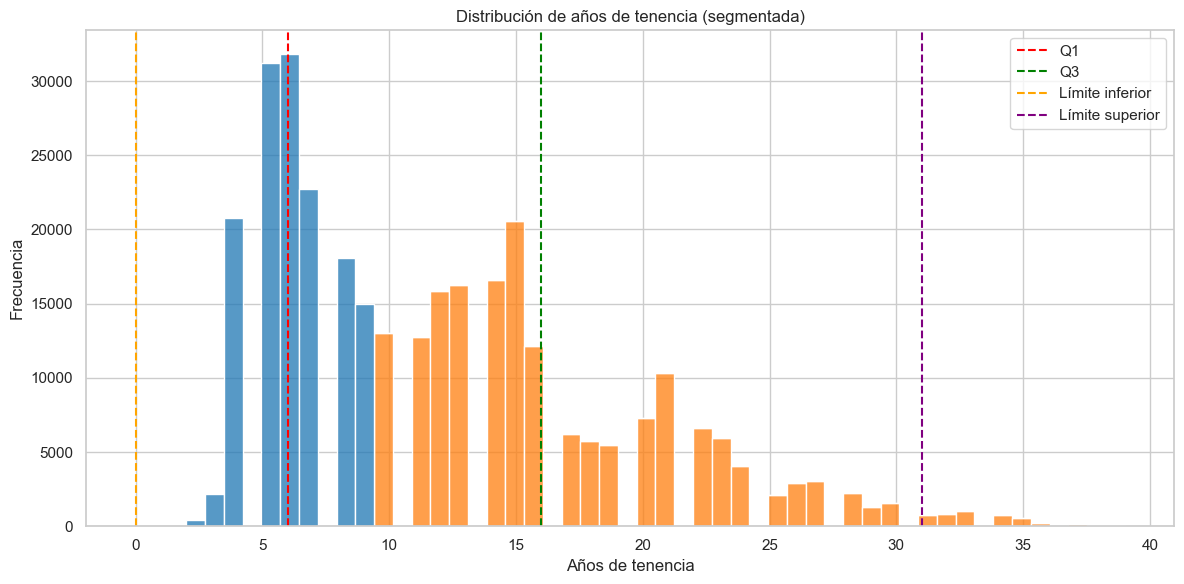

In [21]:
analizar_tenencia_segmentada(df_final)

In [22]:
def analizar_rango_tenencia(df, tenure_col='clnt_tenure_yr', client_id_col='client_id', bins=100):
    """
    Analiza el rango intercuartil (IQR) de la tenencia y grafica su distribución.

    Parámetros:
        df (DataFrame): DataFrame de entrada.
        tenure_col (str): Nombre de la columna de años de tenencia.
        client_id_col (str): Nombre de la columna de identificador de cliente.
        bins (int): Número de bins para el histograma.

    Retorna:
        dict: Estadísticas calculadas (Q1, Q3, IQR, límites y conteos).
    """
    Q1 = df[tenure_col].quantile(0.25)
    Q3 = df[tenure_col].quantile(0.75)
    IQR = Q3 - Q1
    lower_limit = max(Q1 - 1.5 * IQR, 0)
    upper_limit = Q3 + 1.5 * IQR

    num_clientes = df[client_id_col].nunique()
    total = len(df)
    dentro_limites = df[(df[tenure_col] >= lower_limit) & (df[tenure_col] <= upper_limit)].shape[0]
    debajo_limite = df[df[tenure_col] < lower_limit].shape[0]
    encima_limite = df[df[tenure_col] > upper_limit].shape[0]

    print(f"Q1: {Q1}, Q3: {Q3}, IQR: {IQR}")
    print(f"Límite inferior (ajustado): {lower_limit}, Límite superior (Q3 + 1.5 * IQR): {upper_limit}")
    print(f"Cantidad de clientes únicos: {num_clientes}")
    print(f"Total registros: {total}")
    print(f"Registros dentro de los límites: {dentro_limites}")
    print(f"Registros debajo del límite inferior: {debajo_limite}")
    print(f"Registros encima del límite superior: {encima_limite}")

    plt.figure(figsize=(10, 6))
    sns.histplot(
        data=df,
        x=tenure_col,
        bins=bins,
        kde=True,
        color="steelblue"
    )
    plt.title('Distribución de años de tenencia')
    plt.xlabel('Años de tenencia')
    plt.ylabel('Frecuencia')
    plt.axvline(Q1, color='red', linestyle='--', label='Q1')
    plt.axvline(Q3, color='green', linestyle='--', label='Q3')
    plt.axvline(lower_limit, color='orange', linestyle='--', label='Límite inferior (ajustado)')
    plt.axvline(upper_limit, color='purple', linestyle='--', label='Límite superior (Q3 + 1.5 * IQR)')
    plt.legend()
    plt.show()

    return {
        'Q1': Q1,
        'Q3': Q3,
        'IQR': IQR,
        'lower_limit': lower_limit,
        'upper_limit': upper_limit,
        'num_clientes': num_clientes,
        'total': total,
        'dentro_limites': dentro_limites,
        'debajo_limite': debajo_limite,
        'encima_limite': encima_limite
    }


- clnt_tenure_yr y clnt_tenure_mnth: Ambas distribuciones tienen una alta concentración de clientes con menos de 20 años o 240 meses de antigüedad, mostrando muchos valores atípicos (outliers) hacia los extremos superiores.
- clnt_age: La distribución de la edad se centra entre los 30 y 60 años, con pocos clientes menores de 30 o mayores de 80.
- num_accts: La mayoría de los clientes tiene entre 1 y 2 cuentas, con algunos casos aislados que tienen hasta 8 cuentas.
- bal: Hay una alta concentración de balances bajos, con varios valores atípicos que superan los 10 millones.
- logons_6_mnth: Las frecuencias de inicio de sesión en 6 meses varían entre 1 y 9, sin outliers claros.
- calls_6_mnth: Las llamadas en los últimos 6 meses se distribuyen entre 1 y 6, sin valores atípicos.

#### 3. KPIs

#### 3.1 Tasa de finalización

In [ ]:
def estadisticas_completion_rate(df):
    """
    Calcula las tasas de finalización por cliente único,
    usando solo la última interacción de cada cliente.
    """
    # Nos quedamos con el último registro por cliente
    df = df.sort_values('date_time').drop_duplicates('client_id', keep='last')

    results = []
    for variation in ['Control', 'Test']:
        filtered_df = df[df["Variation"] == variation]
        
        completed = (filtered_df['is_complete'] == 1).sum()
        incomplete = (filtered_df['is_complete'] == 0).sum()
        total = completed + incomplete

        results.append({
            'Variation': variation,
            'Completed Clients': completed,
            'Completion Rate (%)': (completed / total) * 100 if total else 0,
        })

    return pd.DataFrame(results)



In [56]:
completion_rate = estadisticas_completion_rate(df_final)
completion_rate.to_csv('data/visualization/completion_rate.csv', index=False)
completion_rate

,Variation,Completed Clients,Completion Rate (%)
0,Control,15286,65.498329
1,Test,18496,69.213786


#### 3.2 Tiempo en cada paso

##### 3.2.1 Tiempo en cada paso general

In [29]:
def calculo_tiempo_pasos_stats(df):
    """
    Calcula estadísticas de tiempo por paso de proceso y por grupo (Control y Test).
    
    Parameters:
        df (DataFrame): DataFrame que contiene la información del tiempo por paso.
        
    Returns:
        DataFrame: Estadísticas de tiempo para cada paso, desglosadas por grupo.
    """
    # Agrupar por 'Variation' y 'process_step' y calcular estadísticas de tiempo
    time_stats_df = df.groupby(['Variation', 'process_step'])['time_diff_step'].agg(['mean', 'min', 'max', 'count']).rename(
        columns={'mean': 'mean_time', 'min': 'min_time', 'max': 'max_time', 'count': 'num_entries'}
    ).reset_index()
    
    return time_stats_df



In [30]:
time_stats_general = calculo_tiempo_pasos_stats(df_final)
time_stats_general

,Variation,process_step,mean_time,min_time,max_time,num_entries
0,Control,confirm,129.046178,0.0,9396.0,16588
1,Control,start,151.886076,0.0,40235.0,16590
2,Control,step_1,43.037307,0.0,4150.0,29137
3,Control,step_2,38.770338,0.0,1724.0,25555
4,Control,step_3,92.975700,0.0,3635.0,22428
5,Test,confirm,129.194520,0.0,14581.0,22116
6,Test,start,147.305936,0.0,24819.0,23263
7,Test,step_1,37.667716,0.0,3636.0,38115
8,Test,step_2,48.276693,0.0,1858.0,30561
9,Test,step_3,96.897236,0.0,1923.0,25398


##### 3.2.2 Tiempo en cada paso por segmento de permanencia y edad.

In [31]:

def medias_tiempo_segmento(df, column):
    # Calcular el tiempo total por visita
    visit_times = df.groupby('visit_id')['time_diff_step'].sum().reset_index()
    visit_times.rename(columns={'time_diff_step': 'time_per_visit_in_sec'}, inplace=True)
    
    # Unir info por visita 
    visit_info = df.drop_duplicates(subset='visit_id')[['visit_id', 'Variation', 'age_segment', 'tenure_segment']]
    visit_data = pd.merge(visit_info, visit_times, on='visit_id', how='left')

    # Inicializar listas
    variations = visit_data[column].unique()
    age_segment_results = []
    tenure_segment_results = []

    for variation in variations:
        filtered_df = visit_data[visit_data[column] == variation]

        # Promedio por segmento de edad
        age_avg = filtered_df.groupby('age_segment')['time_per_visit_in_sec'].mean().reset_index()
        age_avg['Variation'] = variation
        age_avg.rename(columns={'time_per_visit_in_sec': 'Average Time (seconds)'}, inplace=True)
        age_segment_results.append(age_avg)

        # Promedio por segmento de tenure
        tenure_avg = filtered_df.groupby('tenure_segment')['time_per_visit_in_sec'].mean().reset_index()
        tenure_avg['Variation'] = variation
        tenure_avg.rename(columns={'time_per_visit_in_sec': 'Average Time (seconds)'}, inplace=True)
        tenure_segment_results.append(tenure_avg)

    # Concatenar resultados
    df_age_segment_results = pd.concat(age_segment_results).reset_index(drop=True)
    df_tenure_segment_results = pd.concat(tenure_segment_results).reset_index(drop=True)

    # Exportar
    df_age_segment_results.to_csv('data/visualization/average_time_by_age_segment.csv', index=False)
    df_tenure_segment_results.to_csv('data/visualization/average_time_by_tenure_segment.csv', index=False)

    return df_age_segment_results, df_tenure_segment_results




In [32]:
df_age, df_tenure = medias_tiempo_segmento(df_final, 'Variation')
df_tenure

,tenure_segment,Average Time (seconds),Variation
0,long_tenure,321.779985,Test
1,new,310.589327,Test
2,long_tenure,286.473875,Control
3,new,277.158012,Control


In [33]:
df_age

,age_segment,Average Time (seconds),Variation
0,middle,314.153616,Test
1,old,366.714591,Test
2,young,257.306830,Test
3,middle,290.250819,Control
4,old,310.343361,Control
5,young,225.805888,Control


#### 3.3 Tasa de error

##### 3.3.1 Tasa de error general

In [34]:
def error_rate_calculo(df):
    """
    Calcula la tasa de errores en el DataFrame proporcionado para los grupos Control y Test.
    
    Parameters:
        df (DataFrame): DataFrame que contiene la información sobre errores y el grupo (Control o Test).
        
    Returns:
        DataFrame: Un DataFrame con la tasa de errores y el total de registros y errores para ambos grupos.
    """
    # Función interna para calcular la tasa de errores
    def error_stats(group_df):
        total_records = len(group_df)
        total_errors = group_df['is_error'].sum()
        error_rate = (total_errors / total_records) * 100 if total_records > 0 else 0
        return total_records, total_errors, round(error_rate, 2)

    # Calcular estadísticas para el grupo Control
    control_df = df[df['Variation'] == 'Control']
    control_stats = error_stats(control_df)
    
    # Calcular estadísticas para el grupo Test
    test_df = df[df['Variation'] == 'Test']
    test_stats = error_stats(test_df)

    # Crear un DataFrame para devolver los resultados
    result_df = pd.DataFrame({
        'Group': ['Control', 'Test'],
        'Total Records': [control_stats[0], test_stats[0]],
        'Total Errors': [control_stats[1], test_stats[1]],
        'Error Rate (%)': [control_stats[2], test_stats[2]]
    })

    return result_df


In [35]:
error_rate_df = error_rate_calculo(df_final)
error_rate_df

,Group,Total Records,Total Errors,Error Rate (%)
0,Control,142286,9545,6.71
1,Test,176328,16138,9.15


##### 3.3.2 Tasa de error por segmento de edad

In [36]:
# error rate por segmento de edad
def error_rate_segmento_edad_calc(df):
    """
    Calcula la tasa de errores por segmento de edad en el DataFrame proporcionado.
    
    Parameters:
        df (DataFrame): DataFrame que contiene la información sobre errores y segmentos de edad.
        
    Returns:
        DataFrame: Un DataFrame con la tasa de errores por segmento de edad.
    """
    # Agrupar por 'age_segment' y calcular estadísticas de errores
    error_stats = df.groupby('age_segment')['is_error'].agg(['count', 'sum']).reset_index()
    error_stats.rename(columns={'count': 'Total Records', 'sum': 'Total Errors'}, inplace=True)
    
    # Calcular la tasa de errores
    error_stats['Error Rate (%)'] = (error_stats['Total Errors'] / error_stats['Total Records']) * 100
    error_stats['Error Rate (%)'] = error_stats['Error Rate (%)'].round(2)
    
    return error_stats

In [37]:
age_error_rate_df = error_rate_segmento_edad_calc(df_final)
age_error_rate_df

,age_segment,Total Records,Total Errors,Error Rate (%)
0,middle,162539,12529,7.71
1,old,88520,8561,9.67
2,young,67555,4593,6.80


#### 3.3.2 Tasa de error por segmento de permanencia.

In [38]:
# eror rate por segmento de tenencia
def calculate_error_rate_by_tenure_segment(df):
    """
    Calcula la tasa de errores por segmento de tenencia en el DataFrame proporcionado.
    
    Parameters:
        df (DataFrame): DataFrame que contiene la información sobre errores y segmentos de tenencia.
        
    Returns:
        DataFrame: Un DataFrame con la tasa de errores por segmento de tenencia.
    """
    # Agrupar por 'tenure_segment' y calcular estadísticas de errores
    error_stats = df.groupby('tenure_segment')['is_error'].agg(['count', 'sum']).reset_index()
    error_stats.rename(columns={'count': 'Total Records', 'sum': 'Total Errors'}, inplace=True)
    
    # Calcular la tasa de errores
    error_stats['Error Rate (%)'] = (error_stats['Total Errors'] / error_stats['Total Records']) * 100
    error_stats['Error Rate (%)'] = error_stats['Error Rate (%)'].round(2)
    
    return error_stats

In [39]:
tenure_error_rate_df = calculate_error_rate_by_tenure_segment(df_final)

### **4.Contraste de hipotesis**


##### **4.1 Hipótesis sobre la tasa de finalización** 
Comprobar que la diferencia entre tasas test y control, tiene una diferencia estadisticamente considerable. 

H0: La media de tasa de finalización entre grupos es igual

H1: La media de tasa de finalización entre grupos es diferente

In [63]:
def hypothesis_testing_tasa_finalizacion(df, alpha=0.05):
    # Asegurar que las columnas necesarias estén presentes
    required_columns = {'Variation', 'client_id', 'process_step'}
    if not required_columns.issubset(df.columns):
        raise ValueError(f"Faltan columnas requeridas: {required_columns - set(df.columns)}")
    
    # Obtener clientes únicos por grupo
    test_df = df[df['Variation'] == 'Test']
    control_df = df[df['Variation'] == 'Control']
    
    # Clientes únicos por grupo
    unique_test_clients = test_df['client_id'].nunique()
    unique_control_clients = control_df['client_id'].nunique()
    
    # Clientes que completaron el proceso (llegaron a 'confirm')
    test_completions = test_df[test_df['process_step'] == 'confirm']['client_id'].nunique()
    control_completions = control_df[control_df['process_step'] == 'confirm']['client_id'].nunique()

    # Seguridad: no permitir divisiones por cero
    if unique_test_clients == 0 or unique_control_clients == 0:
        raise ValueError("Uno de los grupos no contiene clientes únicos.")
    
    # Prueba z de proporciones
    counts = np.array([test_completions, control_completions])
    nobs = np.array([unique_test_clients, unique_control_clients])
    
    stat, p_value = proportions_ztest(counts, nobs, alternative='larger')

    # Decisión
    if p_value < alpha:
        decision = "Rechaza la hipótesis nula: hay una diferencia significativa en las tasas de finalización."
    else:
        decision = "No se rechaza la hipótesis nula: no hay una diferencia significativa en las tasas de finalización."

    return {
        'z_statistic': stat,
        'p_value': p_value,
        'decision': decision,
        'test_completion_rate': test_completions / unique_test_clients,
        'control_completion_rate': control_completions / unique_control_clients
    }

In [64]:
#llamamos a la funcion para hacer la prueba de hipotesis
hypothesis_results = hypothesis_testing_tasa_finalizacion(df_final)    
print("Resultados de la prueba de hipótesis:")
print(f"Estadística z: {hypothesis_results['z_statistic']:.4f}")
print(f"p-valor: {hypothesis_results['p_value']:.4f}")
print(f"Decisión: {hypothesis_results['decision']}")

Resultados de la prueba de hipótesis:
Estadística z: 8.8528
p-valor: 0.0000
Decisión: Rechaza la hipótesis nula: hay una diferencia significativa en las tasas de finalización.


**Resultado**: El resultado presenta diferencias estadisticas significativas, por lo que se rechaza la hipotesis nula y establece que  se produce un incremento en la tasa de finalización del grupo test, por lo que podemos interpretar que en cierto modo el nuevo diseño mejor la efectividad a la hora de finalizarlo. 

##### **4.2 Hipótesis umbral costo - efectividad**

Umbral : Vanguard ha definido que la tasa de finalización debe aumentar al menos un 5 %. Este porcentaje representa el punto en el que los beneficios esperados —como mayor participación de los usuarios y posibles ingresos adicionales— serán mayores que los costos asociados al nuevo diseño.

Se pide que realices un análisis adicional para confirmar que el incremento observado en la tasa de finalización durante la prueba A/B alcance o supere ese 5 %. Si el nuevo diseño no logra esta mejora mínima, podría no ser rentable implementarlo, aunque los resultados sean estadísticamente significativos.

H0: El aumento de la tasa de finalización no alcanza el umbral del 5%

H1: El aumento en la tasa de finalización es significativo y cumple el umbral del 5%

In [65]:
def hypothesis_testing_finalizacion_threshold (df, cost_effectiveness_threshold=0.05, alpha=0.05):

    # Filtrar los grupos
    df_test = df[df['Variation'] == 'Test']
    df_control = df[df['Variation'] == 'Control']

    # Clientes únicos en cada grupo
    test_total = df_test['client_id'].nunique()
    control_total = df_control['client_id'].nunique()

    # Completaciones: clientes que llegaron al paso 'confirm'
    test_completions = df_test[df_test['process_step'] == 'confirm']['client_id'].nunique()
    control_completions = df_control[df_control['process_step'] == 'confirm']['client_id'].nunique()

    # Calcular tasa de completación del grupo control y ajustarla con el umbral
    control_rate = control_completions / control_total if control_total > 0 else 0
    adjusted_control_rate = control_rate + cost_effectiveness_threshold

    # Prueba de proporciones con tasa esperada ajustada
    stat, p_value = proportions_ztest(
        [test_completions, control_completions],
        [test_total, control_total],
        value=adjusted_control_rate,
        alternative='larger')

    # Decisión
    if p_value < alpha:
        hypothesis_decision = (
            f"Rechaza la hipótesis nula: el aumento en la tasa de completación es significativo y "
            f"supera el umbral establecido por la empresa."
        )
    else:
        hypothesis_decision = (
            f"No se rechaza la hipótesis nula: el aumento no supera el umbral establecido por la empresa."
        )

    return {
        'z_statistic': round(stat, 4),
        'p_value': round(p_value, 4),
        'test_completion_rate': round(test_completions / test_total * 100, 2),
        'control_completion_rate': round(control_rate * 100, 2),
        'adjusted_control_rate': round(adjusted_control_rate * 100, 2),
        'decision': hypothesis_decision
    }


In [66]:
# Ejecutar la prueba de hipótesis con el umbral de costo-efectividad
hypothesis_results = hypothesis_testing_finalizacion_threshold(df_final, cost_effectiveness_threshold=0.05, alpha=0.05)
hypothesis_results

{'z_statistic': np.float64(-159.1229),
 'p_value': np.float64(1.0),
 'test_completion_rate': 69.21,
 'control_completion_rate': 65.5,
 'adjusted_control_rate': 70.5,
 'decision': 'No se rechaza la hipótesis nula: el aumento no supera el umbral establecido por la empresa.'}

 **Resultado** : Debido a que estadisticamente no hay una diferencia significativa y ademas la media entre grupos no alcanza el umbral del 5%, entendemmos que la nueva interfaz no supone un ahorro ni incremento, tanto en el coste como en el beneficio, respectivamente, del nuevo diseño. 

##### **4.3 Hipotesis diferencias de tiempos por pasos**

H0: La media de tasa de finalización entre grupos es igual

H1: La media de tasa de finalización entre grupos es diferente

In [61]:
def hypothesis_test_pasos(df, alpha=0.05):

    # Lista para almacenar los resultados de cada paso
    results = []
    
    # Obtener todos los pasos únicos del proceso
    process_steps = df['process_step'].unique()
    
    # Iterar sobre cada paso
    for step in process_steps:
        # Separar los datos por grupo y paso del proceso
        control_times = df[(df['Variation'] == 'Control') & (df['process_step'] == step)]['time_diff_step']
        test_times = df[(df['Variation'] == 'Test') & (df['process_step'] == step)]['time_diff_step']
        
        # Prueba t para dos muestras independientes
        t_stat, p_value = stats.ttest_ind(control_times, test_times, equal_var=False, nan_policy='omit')
        
        # Decisión sobre la hipótesis nula
        reject_null = p_value < alpha
        decision = "Se rechaza H₀" if reject_null else "No se rechaza H₀"
        
        # Agregar los resultados a la lista
        results.append({
            'process_step': step,
            'Control Mean Time': round(control_times.mean(), 2),
            'Test Mean Time': round(test_times.mean(), 2),
            'T-Statistic': round(t_stat, 4),
            'P-Value': round(p_value, 4),
            'Alpha': alpha,
            'result': decision
        })
    
    # Convertir la lista de resultados a un DataFrame
    results_df = pd.DataFrame(results)
    
    return results_df

In [62]:
hypothesis_test_pasos(df_final, alpha=0.05)

,process_step,Control Mean Time,Test Mean Time,T-Statistic,P-Value,Alpha,result
0,start,151.89,147.31,1.0066,0.3142,0.05,No se rechaza H₀
1,step_1,43.04,37.67,6.9414,0.0000,0.05,Se rechaza H₀
2,step_2,38.77,48.28,-13.4010,0.0000,0.05,Se rechaza H₀
3,step_3,92.98,96.90,-3.5658,0.0004,0.05,Se rechaza H₀
4,confirm,129.05,129.19,-0.0668,0.9467,0.05,No se rechaza H₀


***Conclusion***

- En los pasos **start** y **step_1**, el grupo de prueba fue más rápido, lo que es una mejora en esos puntos.

- En los pasos **step_2** y **step_3**, el grupo de prueba tardó más tiempo, lo que representa un empeoramiento en esos pasos.

- En el paso confirm, no hay cambios relevantes en el tiempo

     **En resumen**:

    - La hipótesis nula se rechaza parcialmente: hay diferencias significativas en algunos pasos, pero no en todos.

    - Por lo que no podemos decir que las medias de los tiempos sean iguales para todo el proceso, pero sí que para ciertos pasos no hay diferencias.

#### **4.4 Hipotesis diferencias en tasas de error**



##### **4.4.1 Hipotesis tasa de error general entre grupos.**

H0: La tasa de error entre los grupos son iguales

H1: La tasa entre los grupos son diferentes

In [ ]:
def hypothesis_test_tasa_de_error (df, alpha=0.05):
    # Filtrar por grupo Control y calcular métricas
    control_df = df[df['Variation'] == 'Control']
    n_control = len(control_df)
    errors_control = control_df['is_error'].sum()
    p_control = errors_control / n_control if n_control > 0 else 0

    # Filtrar por grupo Test y calcular métricas
    test_df = df[df['Variation'] == 'Test']
    n_test = len(test_df)
    errors_test = test_df['is_error'].sum()
    p_test = errors_test / n_test if n_test > 0 else 0

    # Validar que ambos grupos tienen datos
    if n_control == 0 or n_test == 0:
        raise ValueError("Uno de los grupos (Control o Test) no contiene registros.")

    # Proporción combinada y error estándar
    p_combined = (errors_control + errors_test) / (n_control + n_test)
    se_combined = np.sqrt(p_combined * (1 - p_combined) * (1/n_control + 1/n_test))

    # Estadístico Z y p-valor (bilateral)
    z_stat = (p_control - p_test) / se_combined
    p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))

    # Decisión sobre la hipótesis nula
    reject_null = p_value < alpha
    decision = "Se rechaza H₀" if reject_null else "No se rechaza H₀"
    explanation = (
        "Las diferencias en las tasas de error son estadísticamente significativas."
        if reject_null else
        "No hay evidencia suficiente para decir que las tasas de error son significativamente diferentes."
    )

    # Armar resultados en un diccionario y convertir a DataFrame si se desea
    results = {
        'Control Error Rate (%)': round(p_control * 100, 2),
        'Test Error Rate (%)': round(p_test * 100, 2),
        'Z-Statistic': round(z_stat, 4),
        'P-Value': round(p_value, 4),
        'Alpha': alpha,
        'Decision': decision,
        'Explanation': explanation
    }

    return pd.DataFrame([results])


In [68]:
error_results = hypothesis_test_tasa_de_error(df_final, alpha=0.05)
error_results



,Control Error Rate (%),Test Error Rate (%),Z-Statistic,P-Value,Alpha,Decision,Explanation
0,6.71,9.15,-25.1918,0.0,0.05,Se rechaza H₀,Las diferencias en las tasas de error son esta...


##### **4.4.2 Hipotesis tasa de error Edad por grupos**

Evaluar si ha existido diferencia entre las edades por grupo

H0 : No hubo diferencia entre las edades de los grupos

H1 : Si hubo diferencia entre las edades de los grupos

In [ ]:
# Definimos una función para realizar la prueba de hipótesis de segun la edad
def hypothesis_test_tasa_error_edad(df, alpha=0.05):
    """
    Realiza una prueba de hipótesis para comparar las tasas de error entre los segmentos de edad.
    
    Parameters:
        df (DataFrame): DataFrame que contiene la información sobre errores y segmentos de edad.
                        Debe tener las columnas 'age_segment', 'Variation' ('Control' o 'Test') y 'is_error' (0 o 1).
        alpha (float): Nivel de significancia para la prueba.
        
    Returns:
        DataFrame: Resultados de la prueba de hipótesis por segmento de edad.
    """
    age_segments = df['age_segment'].unique()
    results = []

    for segment in age_segments:
        segment_df = df[df['age_segment'] == segment]
        
        control_df = segment_df[segment_df['Variation'] == 'Control']
        test_df = segment_df[segment_df['Variation'] == 'Test']
        
        n_control = len(control_df)
        errors_control = control_df['is_error'].sum()
        p_control = errors_control / n_control if n_control > 0 else 0
        
        n_test = len(test_df)
        errors_test = test_df['is_error'].sum()
        p_test = errors_test / n_test if n_test > 0 else 0

        # Validar que ambos grupos tienen datos para comparar
        if n_control == 0 or n_test == 0:
            continue

        # Proporción combinada y error estándar para prueba de diferencia de proporciones
        p_combined = (errors_control + errors_test) / (n_control + n_test)
        se_combined = np.sqrt(p_combined * (1 - p_combined) * (1/n_control + 1/n_test))

        # Estadístico Z y p-valor (bilateral)
        z_stat = (p_control - p_test) / se_combined
        p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))

        reject_null = p_value < alpha
        decision = "Se rechaza H₀" if reject_null else "No se rechaza H₀"
        explanation = (
            "Las diferencias en las tasas de error son estadísticamente significativas"
            if reject_null else
            "No hay evidencia suficiente para decir que las tasas de error son significativamente diferentes"
        )
        
        results.append({
            'Age Segment': segment,
            'Control Error Rate (%)': round(p_control * 100, 2),
            'Test Error Rate (%)': round(p_test * 100, 2),
            'Z-Statistic': round(z_stat, 4),
            'P-Value': round(p_value, 4),
            'Alpha': alpha,
            'Decision': decision,
            'Explanation': explanation
        })

    return pd.DataFrame(results)

In [ ]:
#llamamos a la funcion para hacer la prueba de hipotesis por segmento de edad
age_segment_results = hypothesis_test_tasa_error_edad(df_final, alpha=0.05)
age_segment_results

,Age Segment,Control Error Rate (%),Test Error Rate (%),Z-Statistic,P-Value,Alpha,Decision,Explanation
0,young,6.37,7.16,-4.0426,0.0001,0.05,Se rechaza H₀,Las diferencias en las tasas de error son esta...
1,middle,6.44,8.74,-17.3029,0.0000,0.05,Se rechaza H₀,Las diferencias en las tasas de error son esta...
2,old,7.48,11.36,-19.3451,0.0000,0.05,Se rechaza H₀,Las diferencias en las tasas de error son esta...


#### 4.6 Hipotesis Error de permanencia por grupos

Evaluar si ha existido diferencia en las tasas de error entre los grupos de edades. 

**H0** : No hubo diferencia entre el tiempo de permanencia de los grupos

**H1** : Si hubo diferencia entre el tiempo de permanencia de los grupos

In [70]:
# definimos una funcion para hacer la prueba de hipotesis por segmento de tenencia
def hypothesis_test_tasa_error_permanencia(df, alpha=0.05):
    """
    Realiza una prueba de hipótesis para comparar las tasas de error entre los segmentos de tenencia.
    
    Parameters:
        df (DataFrame): DataFrame que contiene la información sobre errores y segmentos de tenencia.
                        Debe tener las columnas 'tenure_segment', 'Variation' ('Control' o 'Test') y 'is_error' (0 o 1).
        alpha (float): Nivel de significancia para la prueba.
        
    Returns:
        DataFrame: Resultados de la prueba de hipótesis por segmento de tenencia.
    """
    tenure_segments = df['tenure_segment'].unique()
    results = []

    for segment in tenure_segments:
        segment_df = df[df['tenure_segment'] == segment]
        
        control_df = segment_df[segment_df['Variation'] == 'Control']
        test_df = segment_df[segment_df['Variation'] == 'Test']
        
        n_control = len(control_df)
        errors_control = control_df['is_error'].sum()
        p_control = errors_control / n_control if n_control > 0 else 0
        
        n_test = len(test_df)
        errors_test = test_df['is_error'].sum()
        p_test = errors_test / n_test if n_test > 0 else 0

        # Validar que ambos grupos tienen datos para comparar
        if n_control == 0 or n_test == 0:
            continue

        # Proporción combinada y error estándar para prueba de diferencia de proporciones
        p_combined = (errors_control + errors_test) / (n_control + n_test)
        se_combined = np.sqrt(p_combined * (1 - p_combined) * (1/n_control + 1/n_test))

        # Estadístico Z y p-valor (bilateral)
        z_stat = (p_control - p_test) / se_combined
        p_value = 2 * (1 - stats.norm.cdf(abs(z_stat)))

        reject_null = p_value < alpha
        decision = "Se rechaza H₀" if reject_null else "No se rechaza H₀"
        explanation = (
            "Las diferencias en las tasas de error son estadísticamente significativas"
            if reject_null else
            "No hay evidencia suficiente para decir que las tasas de error son significativamente diferentes"
        )
        results.append({
            'Tenure Segment': segment,
            'Control Error Rate (%)': round(p_control * 100, 2),
            'Test Error Rate (%)': round(p_test * 100, 2),
            'Z-Statistic': round(z_stat, 4),
            'P-Value': round(p_value, 4),
            'Alpha': alpha,
            'Decision': decision,
            'Explanation': explanation
        })
    return pd.DataFrame(results)
#llamamos a la funcion para hacer la prueba de hipotesis por segmento de tenencia
tenure_segment_results = hypothesis_test_tasa_error_permanencia(df_final, alpha=0.05)
tenure_segment_results

,Tenure Segment,Control Error Rate (%),Test Error Rate (%),Z-Statistic,P-Value,Alpha,Decision,Explanation
0,new,6.88,8.70,-12.6410,0.0,0.05,Se rechaza H₀,Las diferencias en las tasas de error son esta...
1,long_tenure,6.57,9.52,-22.4275,0.0,0.05,Se rechaza H₀,Las diferencias en las tasas de error son esta...


**Conclusion**: Se rechaza la Hipotesis nula, las diferencias son estadisticamente significativas, tanto en terminos generales como por segemntación, lo que nos confirma la representacion de la tasa de error por lo que se puede establecer que el nuevo diseño de la web deberia de revisar ciertos puntos con el fin de mejorar esta tasa y disminuirla por debajo del grupo control. 

### 5. Creacion de tablas para importar a Tableau y poder trabajar los KPIS 


La tabla **df_final** se reestructura en tablas de dimensión y de hecho, siguiendo el esquema estrella o snowflake, para facilitar su evaluación en Tableau. Esta división permite:

**1. Mejora en el rendimiento**: Al separar las dimensiones de los hechos evitamos la duplicidad de los datos y mejora el tiempo de respuesta al consultarlos.

**2.Mayor flexibilidad en el análisis**: Las dimensiones permiten filtrar los hechos a través de segmentos como edad, género, o periodo de tiempo, facilitando el análisis.

**3.Simplificación del reporte**: La separación en tablas de dimensiones y hechos permite la creación de cálculos más eficientes en Tableau y crear mejores visualizaciones.

**4. Integridad y consistencia de los datos**: Al estructurar los datos en tablas de dimensiones y hechos, se reduce la redundancia y se asegura que cada entidad (cliente, paso, variación) tenga una única fuente de verdad, facilitando la actualización y el mantenimiento de la información.

**5. Escalabilidad para futuros análisis**: Este modelo permite agregar nuevas dimensiones o métricas (hechos) sin modificar la estructura existente, facilitando la adaptación a nuevas necesidades de negocio o análisis más avanzados en el futuro.

In [71]:
def crear_tablas_dim_fact(df):
    """
    Crea las tablas de dimensiones y hechos para modelo estrella a partir del dataframe principal.

    Parámetros:
        df (DataFrame): DataFrame principal con todas las columnas necesarias.

    Retorna:
        tuple: (dim_client, dim_step, dim_variation, fact_process_steps)
    """
    # ----------------------- #
    # DIM_CLIENT
    # ----------------------- #
    dim_client = df[[
        'client_id', 'clnt_age', 'clnt_tenure_yr', 'gendr',
        'num_accts', 'bal', 'calls_6_mnth', 'logons_6_mnth',
        'tenure_segment', 'age_segment', 'bal_category'
    ]].drop_duplicates()

    # -----------------------#
    # DIM_STEP
    # -----------------------#
    step_order_map = {
        'start': 1, 'step_1': 2, 'step_2': 3, 'step_3': 4,
        'confirm': 5
    }
    dim_step = (
        df[['process_step']]
        .dropna()
        .drop_duplicates()
        .assign(step_order=lambda d: d['process_step'].map(step_order_map),
                is_final=lambda d: d['process_step'].isin(['confirm']))
    )

    # -----------------------#
    # DIM_VARIATION
    # -----------------------#
    dim_variation = df[['Variation']].dropna().drop_duplicates()
    dim_variation = dim_variation.rename(columns={'Variation': 'variation'})
    dim_variation['description'] = [
        'Grupo de prueba' if v == 'Test' else 'Grupo de control'
        for v in dim_variation['variation']
    ]

    # -----------------------#
    # FACT_PROCESS_STEPS
    # -----------------------#
    fact_process_steps = df[[
        'visit_id', 'visitor_id', 'client_id', 'process_step', 'date_time',
        'is_complete', 'time_diff_step', 'time_before_step', 'is_error', 'Variation'
    ]].copy()
    fact_process_steps['step_order'] = fact_process_steps['process_step'].map(step_order_map)

    return dim_client, dim_step, dim_variation, fact_process_steps

# Uso de la función
dim_client, dim_step, dim_variation, fact_process_steps = crear_tablas_dim_fact(df_final)

#Exportar todo a csv 
dim_client.to_csv('data/visualization/dim_client.csv', index=False)
dim_step.to_csv('data/visualization/dim_step.csv', index=False)
dim_variation.to_csv('data/visualization/dim_variation.csv', index=False)
fact_process_steps.to_csv('data/visualization/fact_process_steps.csv', index=False)

